In [67]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import xarray as xr

Estimates on 
* Charge efficiency
* Discharge efficiency
* losses


# Three different loss models

Steen et al. https://www.osti.gov/pages/servlets/purl/1163653  
look at fully mixed (1) and fully stratified model (2) of a TES and building on these observations build a new model (4) that should improve the previous capacity model (3).

Sizing of the tank (images)



(1) fully mixed model

$$loss = U \cdot A (T - T_{amb})$$

How does the area $A$ depend on $capacity$?

$$V = \frac{capacity}{c \rho (T_{max}-T_{amb})} \\
V = \pi r^2 h$$

Assume $h$ to be fixed, then

$$\pi r^2 = \frac{capacity}{h c \rho (T_{max}-T_{amb})} \\
A = 2 \pi r^2 + 2 \pi r h$$

How does temperature $T$ depend on $soc$?

$$soc = \frac{T-T_{min}}{T_{max}-T_{min}}\\
T=soc(T_{max}-T_{min})+T_{min}$$

--------------------

(2) fully stratified model

$$V = \frac{capacity}{} \\
V = \pi r^2 h \\
A = 2 \pi r^2 + 2 \pi h \\
r from cap\\
x from soc\\
loss = U \cdot (2\pi r x + \pi r^2) \cdot (T_{min} - T_{amb}) + U \cdot (2\pi r (h-x) + \pi r^2) \cdot (T_{max} - T_{amb})$$

comment: The heat losses in the fully mixed vs. the fully stratified model are different because of the upper and lower area of the storage, which are assumed to have constant temperature. As the model assumes constant height, their contribution becomes quite large for large storages. This is unrealistic, 

--------------------

(3) capacity model (old DER-CAM)

$$loss = capacity \cdot soc \cdot lossrate$$

--------------------

(4) new model (new DER-CAM)

$$loss = capacity \cdot soc \cdot lossrate + staticlossrate \cdot E_{unuse}$$

In [68]:
def fully_mixed_model(U, temp_min, temp_max, temp_amb,
                      h, c, rho, cap, soc):
    r"""
    Model the losses dependent of
    the average temperature in a
    in a fully mixed tank.
    """
    soc *= 0.01
    r = np.sqrt(cap * 1/(np.pi*h*c*rho*(temp_max - temp_amb)))
    pir2 = cap * 1/(h*c*rho*(temp_max - temp_amb))
    A = 2 * pir2 + 2 * np.pi * r * h
    temp = soc * (temp_max - temp_min) + temp_min
    loss = U * A * (temp - temp_amb)
    return loss
    
def fully_stratified_model(U, temp_min, temp_max, temp_amb,
                           h, c, rho, cap, soc):
    r"""
    Model the losses in a perfectly
    stratified tank with HT and LT
    section and state of charge given
    by the position of the boundary
    """
    soc *= 0.01
    r = np.sqrt(cap * 1/(np.pi*h*c*rho*(temp_max - temp_amb)))
    pir2 = cap * 1/(h*c*rho*(temp_max - temp_amb))
    A = 2 * pir2 + 2 * np.pi * r * h
    x = h * (1 - soc)
    loss_ht = (temp_max - temp_amb)*(2*np.pi*r*(h-x)+np.pi*r**2)*U
    loss_lt = (temp_min - temp_amb)*(2*np.pi*r*x+np.pi*r**2)*U
    loss = loss_ht + loss_lt
    return loss

def capacity_model(loss_rate, cap, soc):
    r"""
    Model the losses as a percentage of
    the total capacity.
    """
    soc *= 0.01
    loss = cap * soc * loss_rate
    return loss
      
def steen_model(storage_loss_rate, static_loss_rate, 
                temp_min, temp_max, temp_amb, cap, soc):
    r"""
    Model the losses as a percentage of
    the total capacity.
    """
    soc *= 0.01
    e_unuse = cap * (temp_min - temp_amb) * 1/(temp_max - temp_min)
    loss = cap * soc * storage_loss_rate + e_unuse * static_loss_rate
    return loss

def schuetz_model():
    return None

def piecewise_stratified_model():
    return None

In [69]:
def generic_sampling(input_dict, results_dict, function):
    r"""
    n-dimensional full sampling, storing as xarray.
    
    Parameters
    ----------
    input_dict : OrderedDict
        Ordered dictionary containing the ranges of the
        dimensions.
    
    results_dict : OrderedDict
        Ordered dictionary containing the dimensions and 
        coordinates of the results of the function.
        
    function : function
        Function to be sampled.
    
    Returns
    -------
    results : xarray.DataArray
    
    sampling : np.array
    
    indices : 
    """
    import itertools as it
    join_dicts = OrderedDict(list(input_dict.items()) + list(results_dict.items()))
    dims = join_dicts.keys()
    coords = join_dicts.values()
    results = xr.DataArray(np.empty([len(v) for v in join_dicts.values()]),
                           dims=dims,
                           coords=coords)

    sampling = np.array(list(it.product(*input_dict.values())))
    indices = np.array(list(it.product(*[np.arange(len(v)) for v in input_dict.values()])))
    
    for i in range(len(sampling)):
        result = function(*sampling[i])
        results[tuple(indices[i])] = result
        
    return results, sampling, indices

# sample fully mixed model
input_dict = OrderedDict([('U', [0.005]),
                          ('temp_min', [65]),
                          ('temp_max', [90]),
                          ('temp_amb', [21]),
                          ('h', [2]),
                          ('c', [0.00117]),
                          ('rho', [1000]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_fully_mixed_model = generic_sampling(input_dict, results_dict, fully_mixed_model)[0]


# sample fully stratified model
input_dict = OrderedDict([('U', [0.005]),
                          ('temp_min', [65]),
                          ('temp_max', [90]),
                          ('temp_amb', [21]),
                          ('h', [2]),
                          ('c', [0.00117]),
                          ('rho', [1000]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_fully_stratified_model = generic_sampling(input_dict, results_dict, fully_stratified_model)[0]

# sample old DER-CAM capacity model
input_dict = OrderedDict([('loss_rate', [0.01]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_capacity_model = generic_sampling(input_dict, results_dict, capacity_model)[0]

# sample new DER-CAM model
input_dict = OrderedDict([('storage_loss_rate', [0.0006]),
                          ('static_loss_rate', [0.00053]),
                          ('temp_min', [65]),
                          ('temp_max', [90]),
                          ('temp_amb', [21]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_steen_model = generic_sampling(input_dict, results_dict, steen_model)[0]


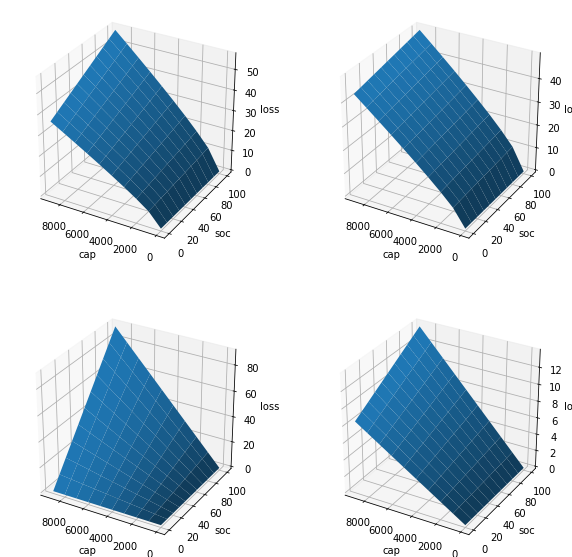

In [70]:
def add_3d_axes(fig, subplot_label, xcoord, ycoord, result):
    X, Y = np.meshgrid(xcoord, ycoord)
    ax = fig.add_subplot(subplot_label, projection='3d')
    ax.plot_surface(X, Y, result)
    ax.invert_xaxis()
    ax.set_xlabel(xcoord.name)
    ax.set_ylabel(ycoord.name)
    ax.set_zlabel('loss')
    return ax

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
add_3d_axes(fig, 221, 
            sam_fully_mixed_model.coords['cap'], 
            sam_fully_mixed_model.coords['soc'], 
            sam_fully_mixed_model.squeeze().values.T)
add_3d_axes(fig, 222, 
            sam_fully_stratified_model.coords['cap'], 
            sam_fully_stratified_model.coords['soc'], 
            sam_fully_stratified_model.squeeze().values.T)
add_3d_axes(fig, 223, 
            sam_capacity_model.coords['cap'], 
            sam_capacity_model.coords['soc'], 
            sam_capacity_model.squeeze().values.T)
add_3d_axes(fig, 224, 
            sam_steen_model.coords['cap'], 
            sam_steen_model.coords['soc'], 
            sam_steen_model.squeeze().values.T)

The Steen publication is a bit confused. What do we learn from that? The losses of an almost empty storage are higher than in the capacity model.

We can describe it the following way: Water is inserted into the tank at a hight temperature level. The losses lead to falling temperature. If the temperature is below a certain level, the energy is not usable any more. 

Then there is stratification. 

# Time evolution

In [71]:
timesteps = 100
soc = []
for t in timesteps:
    soc

TypeError: 'int' object is not iterable

# Proposal: Perfect stratification, different assumption for sizing.

(2) fully stratified model

$$V = \frac{capacity}{} \\
V = \pi r^2 h \\
A = 2 \pi r^2 + 2 \pi h \\
r from cap\\
x from soc\\
loss = U \cdot (2\pi r x + \pi r^2) \cdot (T_{min} - T_{amb}) + U \cdot (2\pi r (h-x) + \pi r^2) \cdot (T_{max} - T_{amb})$$

comment: The heat losses in the fully mixed vs. the fully stratified model are different because of the upper and lower area of the storage, which are assumed to have constant temperature. As the model assumes constant height, their contribution becomes quite large for large storages. This is unrealistic, 


TODO: ambient temperature dependence?



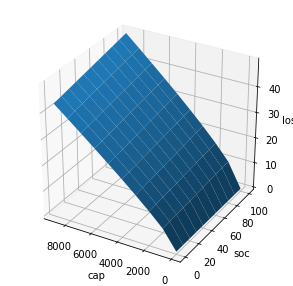

In [74]:
def new_stratified_model(U, temp_min, temp_max, temp_amb,
                           h, c, rho, cap, soc):
    r"""
    Model the losses in a perfectly
    stratified tank with HT and LT
    section and state of charge given
    by the position of the boundary
    """
    soc *= 0.01
    r = np.sqrt(cap * 1/(np.pi*h*c*rho*(temp_max - temp_amb)))
    pir2 = cap * 1/(h*c*rho*(temp_max - temp_amb))
    A = 2 * pir2 + 2 * np.pi * r * h
    x = h * (1 - soc)
    loss_ht = (temp_max - temp_amb)*(2*np.pi*r*(h-x)+np.pi*r**2)*U
    loss_lt = (temp_min - temp_amb)*(2*np.pi*r*x+np.pi*r**2)*U
    loss = loss_ht + loss_lt
    return loss

# sample fully stratified model
input_dict = OrderedDict([('U', [0.005]),
                          ('temp_min', [65]),
                          ('temp_max', [90]),
                          ('temp_amb', [21]),
                          ('h', [2]),
                          ('c', [0.00117]),
                          ('rho', [1000]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_new_stratified_model = generic_sampling(input_dict, results_dict, new_stratified_model)[0]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5))
add_3d_axes(fig, 111, 
            sam_new_stratified_model.coords['cap'], 
            sam_new_stratified_model.coords['soc'], 
            sam_new_stratified_model.squeeze().values.T)

Thermocline thickness studies: http://ijens.org/108601-2424%20IJMME-IJENS.pdf  
More simulations https://www.mdpi.com/1996-1073/11/5/1049/htm#energies-11-01049-f005  
Thermocline http://orbit.dtu.dk/files/4036196/260%20Fan%20J.pdf

# 1D simulation models


* multinode model
 * fixed inlet
 * variable inlet
* Plug flow
* adaptive model https://www.sciencedirect.com/science/article/pii/S0196890413005177

From Kleinbach
<img from src="Screenshot_2019-01-28_18-16-06.png">

To avoid mixing, a maximum charge/discharge flow is to be assumed.  
Numerical diffusion is a problem for multinode models with few nodes

From https://www.sciencedirect.com/science/article/pii/S0196890413005177
<img from src="Screenshot_2019-01-28_17-13-18.png">
<img from src="Screenshot_2019-01-28_15-28-15.png">


1) Kontinuierlich
$$\frac{\partial T}{\partial t} = \alpha \frac{\partial ^2T}{\partial x^2} + \beta (\dot{m}_{source}-\dot{m}_{sink})\frac{\partial T}{\partial x}+ f(T)\\
\alpha=\frac{\epsilon}{\rho c_p}\\
\beta=\frac{1}{\rho A}\\
f(T)=-\frac{UP}{\rho c_p A}(T-T_{amb})$$

2) Diskretisiert
$$\frac{\partial T_i}{\partial t} = \alpha \frac{T_{i+1}-2T_{i}+T_{i-1}}{\Delta x^2} + \beta \dot{m}_{source}\frac{T_{i+1}-T_i}{\Delta x} + \beta \dot{m}_{sink}\frac{T_{i-1}-T_i}{\Delta x}+f(T)\\
$$

In [46]:
import numpy as np
import time
import matplotlib.pyplot as plt

def ode_FE(f, U_0, dt, T):
    N_t = int(round(float(T)/dt))
    # Ensure that any list/tuple returned from f_ is wrapped as array
    f_ = lambda u, t: np.asarray(f(u, t))
    u = np.zeros((N_t+1, len(U_0)))
    t = np.linspace(0, N_t*dt, len(u))
    u[0] = U_0
    for n in range(N_t):
        u[n+1] = u[n] + dt*f_(u[n], t[n])
    return u, t

def rhs(u, t):
    N = len(u) - 1
    rhs = np.zeros(N+1)
    
    i = 0
    rhs[i] = (alpha/dx**2)*(u[i+1] - u[i] - 2*dx*dudx_start(t)) + \
             (beta/dx) * m_source * (u[i+1] - u[i]) + \
             (beta/dx) * m_sink * (u[i+1] - 2*dx*dudx(t) - u[i]) - \
             U * P * 1/(rho * c * A)*(u[i] - T_amb)
    
    for i in range(1, N):
        rhs[i] = (alpha/dx**2)*(u[i+1] - 2*u[i] + u[i-1]) + \
                 (beta/dx) * m_source * (u[i+1] - u[i]) + \
                 (beta/dx) * m_sink * (u[i-1] - u[i]) - \
                 U * P * 1/(rho * c * A)*(u[i] - T_amb)
        
    i = N
    rhs[i] = (alpha/dx**2)*(2*dx*dudx(t) - 2*u[i] + 2*u[i-1]) + \
             (beta/dx) * m_source * (u[i-1] + 2*dx*dudx(t) - u[i]) + \
             (beta/dx) * m_sink * (u[i-1] - u[i]) - \
             U * P * 1/(rho * c * A)*(u[i] - T_amb)
    
#     rhs = np.zeros(N+1)
    
#     rhs[0] = dsdt(t)
#     for i in range(1, N):
#         rhs[i] = (beta/dx**2)*(u[i+1] - 2*u[i] + u[i-1]) + \
#                  g(x[i], t)
#     i = N
#     rhs[i] = (beta/dx**2)*(2*u[i-1] + 2*dx*dudx(t) -
#                            2*u[i]) + g(x[N], t)
    return rhs

def dudx_start(t):
    return 0

def dudx_end(t):
    return 0

def dsdt(t):
    return 0

def s(t):
    return 323

height = 0.5 # height of the storage
n_nodes = 40 # number of nodes
x = np.linspace(0, height, n_nodes+1)
dx = x[1] - x[0]
u = np.zeros(n_nodes+1)

alpha = 8.2E-5
beta = 8.2E-3
rho = 1000
c = 3
U = 1
P = 1
A = 1

m_source = 0
m_sink = 0

T_0 = 273 + 95
T_amb = 273 + 60
U_0 = np.array([T_0]*(n_nodes+1))
U_0[:20] = 273 + 60
print(U_0)
dt = dx**2/(2*beta)
print('stability limit:', dt)
u, t = ode_FE(rhs, U_0, dt, T=1*60*10)

[333 333 333 333 333 333 333 333 333 333 333 333 333 333 333 333 333 333
 333 333 368 368 368 368 368 368 368 368 368 368 368 368 368 368 368 368
 368 368 368 368 368]
stability limit: 0.009527439024390245


[344.7607646  344.77727006 344.81018162 344.85930121 344.92433317
 345.00488611 345.10047522 345.2105252  345.33437374 345.47127554
 345.62040673 345.78086992 345.95169955 346.13186776 346.32029051
 346.5158342  346.71732242 346.92354309 347.13325572 347.3451989
 347.55809787 347.77067222 347.98164354 348.18974318 348.3937198
 348.59234694 348.78443039 348.96881532 349.14439327 349.31010877
 349.46496569 349.60803321 349.73845143 349.85543649 349.95828531
 350.04637977 350.11919045 350.1762798  350.21730473 350.24201872
 350.25027325]


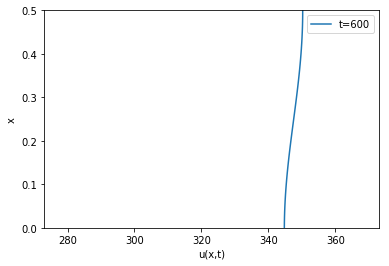

In [49]:
i=62976
y = u[0,:]
lines = plt.plot(y, x)
plt.axis([273, s(0)+50, x[0], x[-1]])
plt.xlabel('u(x,t)')
plt.ylabel('x')
plt.legend(['t=%.0f' % t[i]] )
lines[0].set_xdata(u[i,:])
plt.draw()
print(u[i,:])

The following example is taken from https://link.springer.com/chapter/10.1007/978-3-319-32428-9_5#Equ5
and solves this equation
$$\frac{\partial u}{\partial t} = \beta \frac{\partial ^2u}{\partial x^2} + g(x, t)$$

stability limit: 0.9527439024390245
CPU time: 0.0s


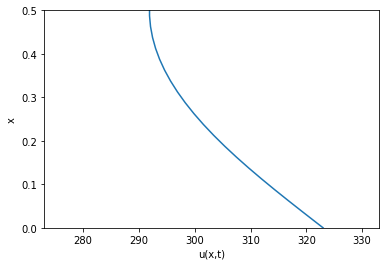

In [13]:
"""Temperature evolution in a rod, computed by a ForwardEuler method."""


def rhs(u, t):
    N = len(u) - 1
    rhs = np.zeros(N+1)
    
    rhs[0] = dsdt(t)
    
    for i in range(1, N):
        rhs[i] = (beta/dx**2)*(u[i+1] - 2*u[i] + u[i-1]) + \
                 g(x[i], t)
    i = N
    rhs[i] = (beta/dx**2)*(2*u[i-1] + 2*dx*dudx(t) -
                           2*u[i]) + g(x[N], t)
    return rhs

def dudx(t):
    return 0

def s(t):
    return 323

def dsdt(t):
    return 0

def g(x, t):
    return 0


L = 0.5
beta = 8.2E-5
N = 40
x = np.linspace(0, L, N+1)
dx = x[1] - x[0]
u = np.zeros(N+1)

U_0 = np.zeros(N+1)
U_0[0] = s(0)
U_0[1:] = 283
dt = dx**2/(2*beta)
print('stability limit:', dt)
#dt = 0.00034375

t0 = time.clock()

u, t = ode_FE(rhs, U_0, dt, T=1*60*10)
t1 = time.clock()
print('CPU time: %.1fs' % (t1 - t0))
t
# Make movie
import os
os.system('rm tmp_*.png')
import matplotlib.pyplot as plt
plt.ion()
y = u[0,:]
lines = plt.plot(y, x)
plt.axis([273, s(0)+10, x[0], x[-1]])
plt.xlabel('u(x,t)')
plt.ylabel('x')
counter = 0
i=630
lines[0].set_xdata(u[i,:])
plt.draw()
# # Plot each of the first 100 frames, then increase speed by 10x
# change_speed = 100
# for i in range(0, u.shape[0]):
#     print(t[i])
#     plot = True if i <= change_speed else i % 10 == 0
#     lines[0].set_xdata(u[i,:])
#     if i > change_speed:
#         plt.legend(['t=%.0f 10x' % t[i]])
#     else:
#         plt.legend(['t=%.0f' % t[i]])
#     plt.draw()
#     if plot:
#         plt.savefig('tmp_%04d.png' % counter)
#         counter += 1
#time.sleep(0.2)

In [100]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.vector().array() - u.vector().array()).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
interactive()

NameError: name 'UnitSquareMesh' is not defined

# Current oemof representation

In [61]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
from oemof.solph.components import GenericStorage
import oemof.outputlib as outputlib
solver = 'cbc'

def draw_graph(energysystem, edge_labels=True, node_color='#eeac7e',
               edge_color='#eeac7e', plot=True, node_size=5500,
               with_labels=True, arrows=True, layout='dot'):
    
    grph = graph.create_nx_graph(energysystem)
    
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
     'prog': 'dot',
     'with_labels': with_labels,
     'node_color': node_color,
     'edge_color': edge_color,
     'node_size': node_size,
     'arrows': arrows,
     'font_size': 12,
     'font_color': 'w'
    }

    # draw graph
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog=layout)

    nx.draw(grph, pos=pos, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()

        
def create_heat_demand():
    import demandlib.bdew as bdew
    from workalendar.europe import Germany
    cal = Germany()
    holidays = dict(cal.holidays(2016))
    filename = 'example_data.csv'
    temperature = pd.read_csv(filename)["temperature"]
    
    # create a DataFrame to hold the timeseries
    heat_demand = pd.DataFrame(
        index=pd.date_range(pd.datetime(2010, 1, 1, 0),
                            periods=8760, freq='H'))


    # Single family house (efh: Einfamilienhaus)
    heat_demand['efh'] = bdew.HeatBuilding(
        heat_demand.index, holidays=holidays, temperature=temperature,
        shlp_type='EFH',
        building_class=1, wind_class=1, annual_heat_demand=25000,
        name='EFH').get_bdew_profile()
    return heat_demand


def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=8760, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=',')
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bgas = Bus(label='gas', balanced=False)
    bth = Bus(label='heat', balanced=True)
    energysystem.add(bgas, bth)
    
    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_heat', inputs={bth: Flow()}))
    energysystem.add(Source(label='shortage_heat',
                         outputs={bth: Flow(variable_costs=100000)}))

    # demands (heat)
    heat_demand = create_heat_demand()['efh']
    energysystem.add(Sink(label='demand_th', inputs={bth: Flow(
        nominal_value=85, actual_value=heat_demand, fixed=True)}))
    
    return bgas, bth, energysystem


def postprocess_and_plot(optimization_model, start, end):
    results = outputlib.processing.results(optimization_model)

    soc = outputlib.views.node(results, 'storage_heat')['sequences'][(('storage_heat', 'None'), 'capacity')]
    losses = soc * capacity_loss
    results_th = outputlib.views.node(results, 'heat')
    th_sequences = results_th['sequences']
    th_sequences[(('heat', 'storage_heat'), 'flow')] *= -1
    th_prod = th_sequences.drop(columns=[(('heat', 'demand_th'), 'flow')])
    
    fig, axs = plt.subplots(3, 1, figsize=(14, 6))
    th_prod[start:end].plot.area(ax=axs[0])
    th_sequences[(('heat', 'demand_th'), 'flow')][start:end].plot(ax=axs[0], linewidth=3, c='k')
    legend = axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot
    
    soc[start:end].plot(ax=axs[1])
    losses.loc[start:end].plot(ax=axs[2])
    return bgas, bth, energysystem

In [57]:
bgas, bth, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='gas_boiler',
    inputs={bgas: Flow()},
    outputs={bth: Flow(nominal_value=500, variable_costs=40)},
    conversion_factors={bth: 0.50}))

capacity_loss=0.01
energysystem.add(GenericStorage(
    label='storage_heat',
    nominal_capacity=10000,
    inputs={bth: Flow(
        variable_costs=0,
        nominal_value=200)},
    outputs={bth: Flow(
        nominal_value=200)},
    capacity_loss=capacity_loss,
    inflow_conversion_factor=1,
    outflow_conversion_factor=1))

# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 3970217530.0, 'Upper bound': 3970217530.0, 'Number of objectives': 1, 'Number of constraints': 26281, 'Number of variables': 61321, 'Number of nonzeros': 96361, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'Termination condition': 'optimal', 'Error rc': 0, 'Time': 0.8929026126861572}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

("<oemof.solph.network.Bus: 'gas'>",
 "<oemof.solph.network.Bus: 'heat'>",
 <oemof.solph.network.EnergySystem at 0x7fd1b1c4e438>)

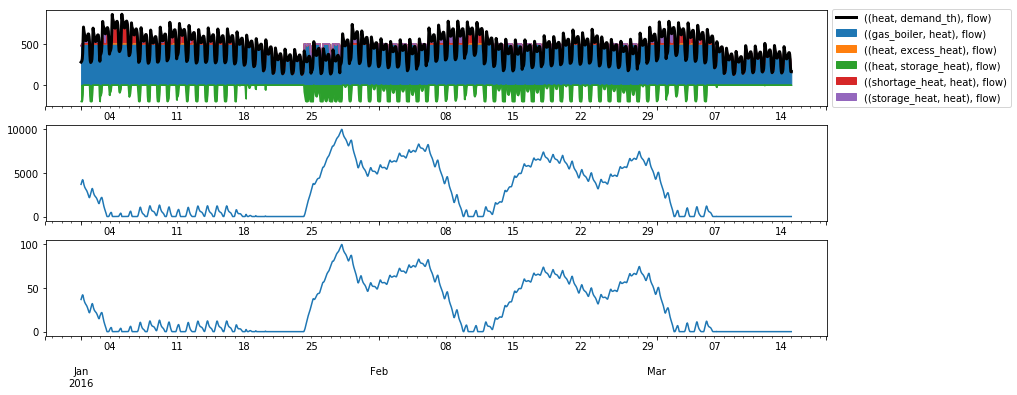

In [64]:
postprocess_and_plot(optimization_model, '2016-1-1 00:00:00', '2016-3-15 00:00:00')

("<oemof.solph.network.Bus: 'gas'>",
 "<oemof.solph.network.Bus: 'heat'>",
 <oemof.solph.network.EnergySystem at 0x7fd1b1c4e438>)

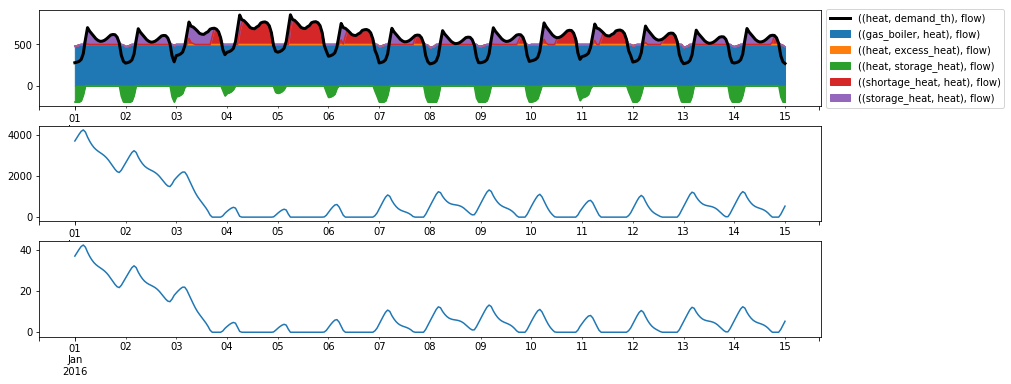

In [65]:
postprocess_and_plot(optimization_model, '2016-1-1 00:00:00', '2016-1-15 00:00:00')

# Seasonal storage

Simulation method for a pit seasonal thermal energy storage system
with a heat pump in a district heating system https://www.sciencedirect.com/science/article/abs/pii/S0360544218305619?via=ihub